# Ray et al 2013 Extract-Transform-Load
**Authorship:**
Adam Klie, *08/11/2022*
***
**Description:**
Notebook to extract, transform, and load (ETL) data from the Ray et al (2013) dataset.
***

In [16]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [2]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# EUGENe imports
import eugene as eu
from eugene import preprocess as pp
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/"

# EUGENe packages
import seqdatasets
import seqdata as sd
import seqpro as sp

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Eugene version: {eu.__version__}")
#print(f"SeqDatasets version: {seqdatasets.__version__}")
#print(f"SeqData version: {sd.__version__}")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Pandas version: 1.5.2
Xarray version: 2023.4.0
Eugene version: 0.0.8


# Download and load in the dataset to a raw `SeqData` object

In [2]:
# Load in the downloaded data, or download it if it's not there
#sdata_raw = eu.datasets.ray13()

In [ ]:
# Load auxiliary data as well
#hg19_motif_hits
#41587_2015_BFnbt3300_MOESM53_ESM.xlsx
#hg19_motif_hits.tar.gz
#z_scores.txt.gz
#e_scores.txt.gz

In [3]:
# For now hack to get things working until I can sort out SeqData error
sdataframe = pd.read_csv("/cellar/users/aklie/data/eugene/revision/ray13/norm_data.txt.gz", na_values=" NaN", sep="\t", low_memory=False)
sdata = xr.Dataset.from_dataframe(sdataframe)
sdata = sdata.rename_dims({"index": "_sequence"})
sdata = sdata.drop_vars("index")

In [4]:
# Get a list of only the target columns
column_keys = pd.Index(sdata.data_vars.keys())
target_mask = column_keys.str.contains("RNCMPT")
target_cols = column_keys[target_mask]
random_idxs = np.random.choice(np.arange(len(target_cols)), size=9, replace=False)
random_cols = target_cols[random_idxs]
len(target_cols)

244

In [5]:
# Necessary step right now but don't want it to be in future
sdata[target_cols] = sdata[target_cols].astype(float)

In [6]:
# Subset to set type (A -- training or B -- testing)
sdata_setA = sdata.sel(_sequence=sdata["Probe_Set"] == "SetA")
sdata_setB = sdata.sel(_sequence=sdata["Probe_Set"] == "SetB")

# Preprocess the training set

In [7]:
sdata_setA

<xarray.Dataset>
Dimensions:      (_sequence: 120326)
Dimensions without coordinates: _sequence
Data variables: (12/247)
    Probe_Set    (_sequence) object 'SetA' 'SetA' 'SetA' ... 'SetA' 'SetA'
    RNA_Seq      (_sequence) object 'AGAAGGCACCAACAGAAGCUCUAACCAGACUAGCCACC' ...
    Probe_ID     (_sequence) object 'RBD_v3_000001' ... 'RBD_v3_120326'
    RNCMPT00100  (_sequence) float64 1.122 8.84 -0.3532 ... -0.05961 -0.008099
    RNCMPT00101  (_sequence) float64 1.273 -2.113 -0.1835 ... 0.1204 -0.08841
    RNCMPT00102  (_sequence) float64 -1.09 2.397 -0.467 ... -0.2655 0.4871
    ...           ...
    RNCMPT00094  (_sequence) float64 -0.1154 -0.3888 -0.6408 ... -0.6807 0.6586
    RNCMPT00095  (_sequence) float64 0.1264 -0.3483 0.05469 ... -0.6874 0.1158
    RNCMPT00096  (_sequence) float64 1.01 0.2165 -1.352 ... 1.965 0.8421 -1.291
    RNCMPT00097  (_sequence) float64 -0.1234 -1.098 0.4701 ... -0.1259 -0.2788
    RNCMPT00099  (_sequence) float64 -0.06065 3.821 -0.05799 ... -0.0563 0.9785
    RNCMPT00009  (_sequence) float64 -0.3989 nan -1.058 nan ... nan nan 1.095

## Preprocess the seqs
- Padded elements of sequences are replaced with a one hot encoded value of 0.25 spanning each base.

In [7]:
import sys
sys.path.append("/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/scripts/ray13")
from ray13_helpers import ohe_seqs

In [8]:
# My hacky fix for now
sdata_setA["ohe_seq"] = xr.DataArray(ohe_seqs(sdata_setA["RNA_Seq"].values, vocab="RNA", seq_align="center", fill_value=0.25), dims=["_sequence", "_ohe", "length"])
sdata_setB["ohe_seq"] = xr.DataArray(ohe_seqs(sdata_setB["RNA_Seq"].values, vocab="RNA", seq_align="center", fill_value=0.25), dims=["_sequence", "_ohe", "length"])

One-hot encoding sequences:   0%|          | 0/120326 [00:00<?, ?it/s]

One-hot encoding sequences:   0%|          | 0/121031 [00:00<?, ?it/s]

In [8]:
seqs = sdata_setA["RNA_Seq"].values

In [9]:
print(f"Max seq len: {np.max(sp.length(seqs))}")

Max seq len: 41


In [10]:
sp.pad_seqs?

Signature:
sp.pad_seqs(
    seqs: Union[str, List[str], numpy.ndarray[Any, numpy.dtype[Union[numpy.str_, numpy.bytes_, numpy.uint8]]]],
    pad: Literal['left', 'both', 'right'],
    pad_value: Optional[str] = None,
    length: Optional[int] = None,
    length_axis: Optional[int] = None,
) -> numpy.ndarray[typing.Any, numpy.dtype[typing.Union[numpy.bytes_, numpy.uint8]]]
Docstring:
_summary_

Parameters
----------
seqs : Iterable[str]
pad : Literal["left", "both", "right"]
    How to pad. If padding on both sides and an odd amount of padding is needed, 1
    more pad value will be on the right side.
pad_val : str, optional
    Single character to pad sequences with. Ignored for OHE sequences.
length : int, optional
    Length to pad or truncate sequences to. If not given, uses length of longest
    sequence.

Returns
-------
Array of padded or truncated sequences.
File:      ~/projects/ML4GLand/SeqPro/seqpro/_encoders.py
Type:      function

In [17]:
seqs

array(['AGAAGGCACCAACAGAAGCUCUAACCAGACUAGCCACC',
       'AGAGGUCGAGUAUUAGUGAUAUUAGAGUGAGGUCCAUC',
       'AGAGAUGACUAUGCAUGCGAUGCUACGCUGAUCCCUGG', ...,
       'AGACAGGGUCUACUGCCGGCAUGGGGUUCC', 'AGGUUGAUUGUCGGAAUAGUUACGUUUGUC',
       'AGGCCUUUUAAAGUUCUUAGAGUCCGCUACACGGUGCG'], dtype=object)

In [18]:
padded_seqs = sp.pad_seqs(
    seqs=seqs,
    pad="both",
    pad_value="N",
    length=41
)

In [23]:
ohe_seqs = sp.ohe(padded_seqs, sp.ALPHABETS["RNA"])

In [37]:
ohe_seqs = ohe_seqs.astype(float)

In [38]:
# If the last axis is all 0s, replace it with 0.25
ohe_seqs[(ohe_seqs == 0).all(-1)] = np.array([0.25, 0.25, 0.25, 0.25])

In [39]:
ohe_seqs[0]

array([[0.25, 0.25, 0.25, 0.25],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  ],
       [0.

In [19]:
sp.length(padded_seqs)

array([41, 41, 41, ..., 41, 41, 41])

In [15]:
padded_seqs.shape

(120326, 41)

## Preprocess the targets
- The values of probe intensities are clamped at 99.95% percentile per binding protein to eliminate outliers and balance the data.
- The probe intensities are normalized to a mean of 0 and a standard deviation of 1.

In [9]:
# Split only those training sequences in SetA into train and validation sets
pp.train_test_split_sdata(sdata_setA, id_var="Probe_ID", test_size=0.2)

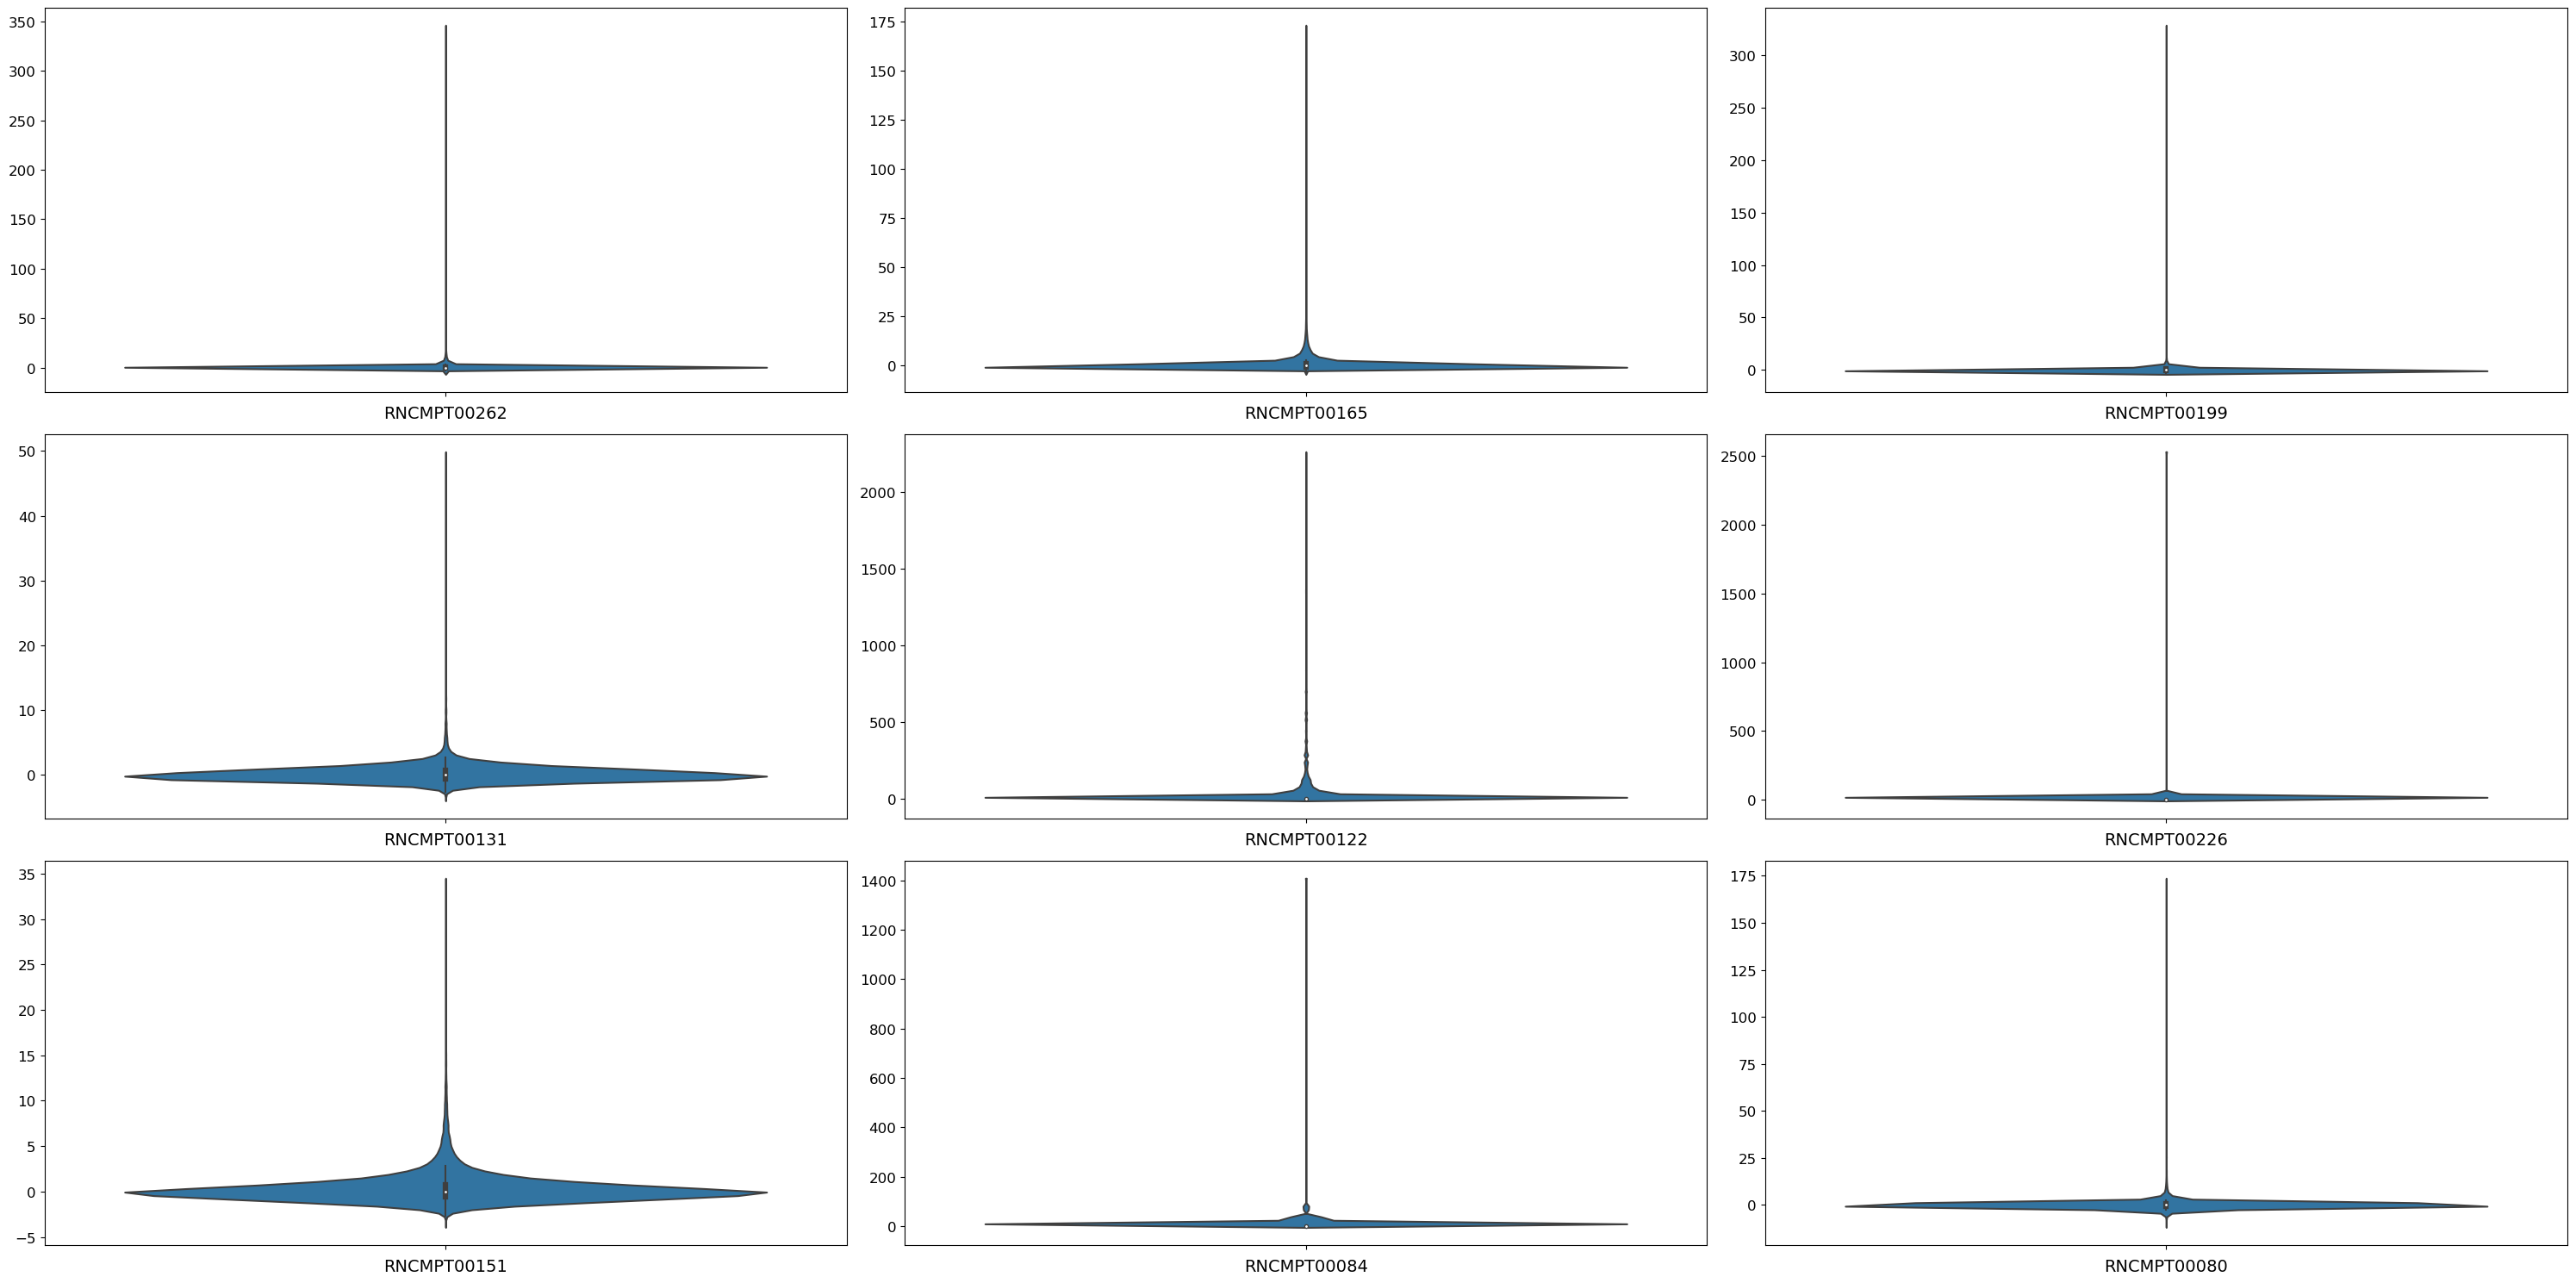

In [8]:
# Plot the distribution of the targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

In [10]:
# Clamp the targets based on percentiles
pp.clamp_targets_sdata(sdata_setA, target_keys=target_cols, percentile=0.9995, train_key="train_val", store_clamp_nums=True)

In [11]:
# Check the distribution of the clamped targets
sdata_setA[random_cols].to_dataframe().describe()

,RNCMPT00262,RNCMPT00165,RNCMPT00199,RNCMPT00131,RNCMPT00122,RNCMPT00226,RNCMPT00151,RNCMPT00084,RNCMPT00080
count,120303.000000,119719.000000,120291.000000,120321.000000,120275.000000,120316.000000,119721.000000,119613.000000,120326.000000
mean,0.290364,0.648682,0.235242,0.176108,1.451198,0.539966,0.302548,0.212326,0.047546
std,1.742079,2.775017,1.281410,1.310905,15.673942,2.551047,1.637816,1.687518,1.769497
min,-6.356256,-3.803116,-3.746352,-3.716635,-7.567417,-5.569531,-3.631931,-4.237045,-11.506036
25%,-0.581649,-0.586884,-0.612549,-0.607603,-0.606123,-0.601148,-0.603305,-0.627383,-0.654234
50%,0.000824,-0.000228,0.000057,0.000707,-0.001238,-0.006341,-0.000885,-0.000826,-0.000097
75%,0.810065,0.863163,0.780282,0.741951,0.738503,0.816165,0.776406,0.734385,0.688387
max,22.667843,39.277073,12.196100,19.948473,476.839499,40.043609,16.779537,30.859128,32.218491


In [12]:
# Make sure they match up with stored values
sdata_setA["clamp_nums"][random_idxs]

<xarray.DataArray 'clamp_nums' (_targets: 9)>
array([ 22.66784307,  39.27707298,  12.19609977,  19.94847274,
       476.83949934,  40.04360935,  16.77953726,  30.85912787,
        32.21849076])
Coordinates:
  * _targets  (_targets) object 'RNCMPT00262' 'RNCMPT00165' ... 'RNCMPT00080'

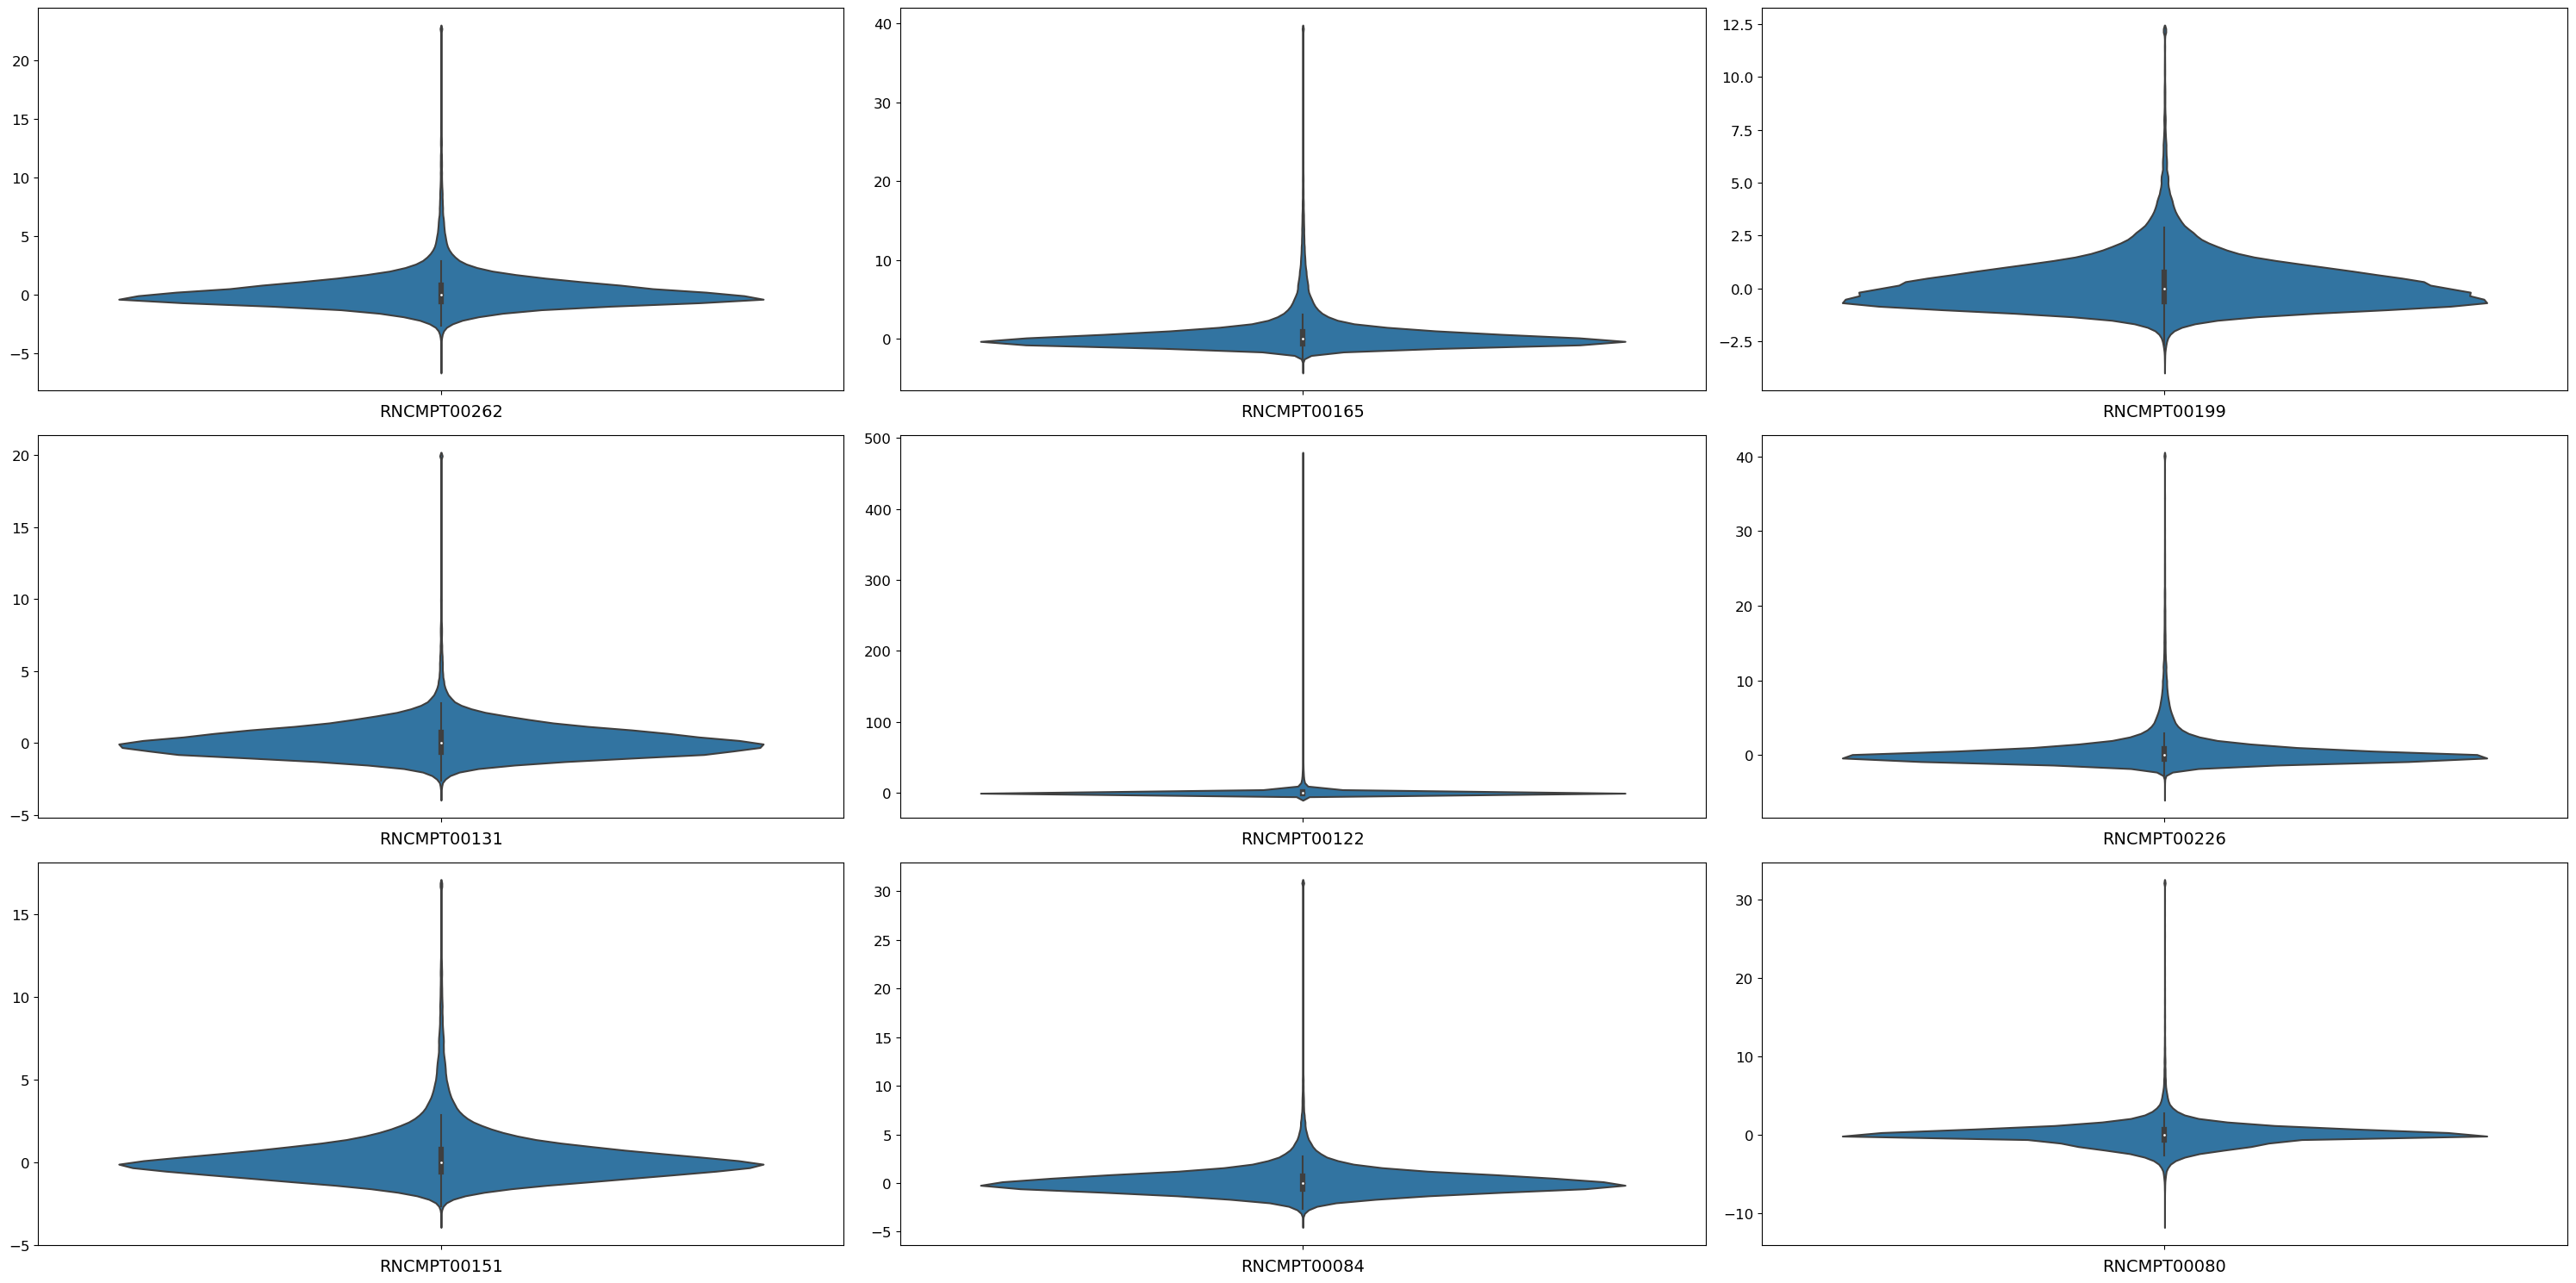

In [13]:
# Plot the distribution of the clamped targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

In [14]:
# Scale the targets have mean 0 and variance 1
scaler = pp.scale_targets_sdata(sdata_setA, target_keys=target_cols, train_key="train_val", return_scaler=True)

In [15]:
# Check the distribution of the scaled targets, should be approximately normal but not exactly
sdata_setA[random_cols].to_dataframe().describe()

,RNCMPT00262,RNCMPT00165,RNCMPT00199,RNCMPT00131,RNCMPT00122,RNCMPT00226,RNCMPT00151,RNCMPT00084,RNCMPT00080
count,120303.000000,119719.000000,120291.000000,120321.000000,120275.000000,120316.000000,119721.000000,119613.000000,120326.000000
mean,-0.001517,-0.002477,0.004355,-0.000737,-0.003068,-0.001847,-0.002644,0.000778,-0.002539
std,1.000271,0.996241,1.009011,1.002093,0.962220,0.990732,0.998092,0.999151,0.990684
min,-3.817891,-1.600688,-3.130843,-2.976462,-0.556718,-2.374547,-2.400332,-2.633618,-6.471014
25%,-0.502212,-0.446050,-0.663215,-0.599829,-0.129366,-0.445013,-0.554675,-0.496399,-0.395443
50%,-0.167766,-0.235438,-0.180835,-0.134819,-0.092232,-0.214012,-0.187557,-0.125425,-0.029213
75%,0.296886,0.074522,0.433533,0.431810,-0.046820,0.105419,0.286127,0.309881,0.356246
max,12.847243,13.865249,9.422608,15.113830,29.180914,15.339896,10.038503,18.146225,18.008925


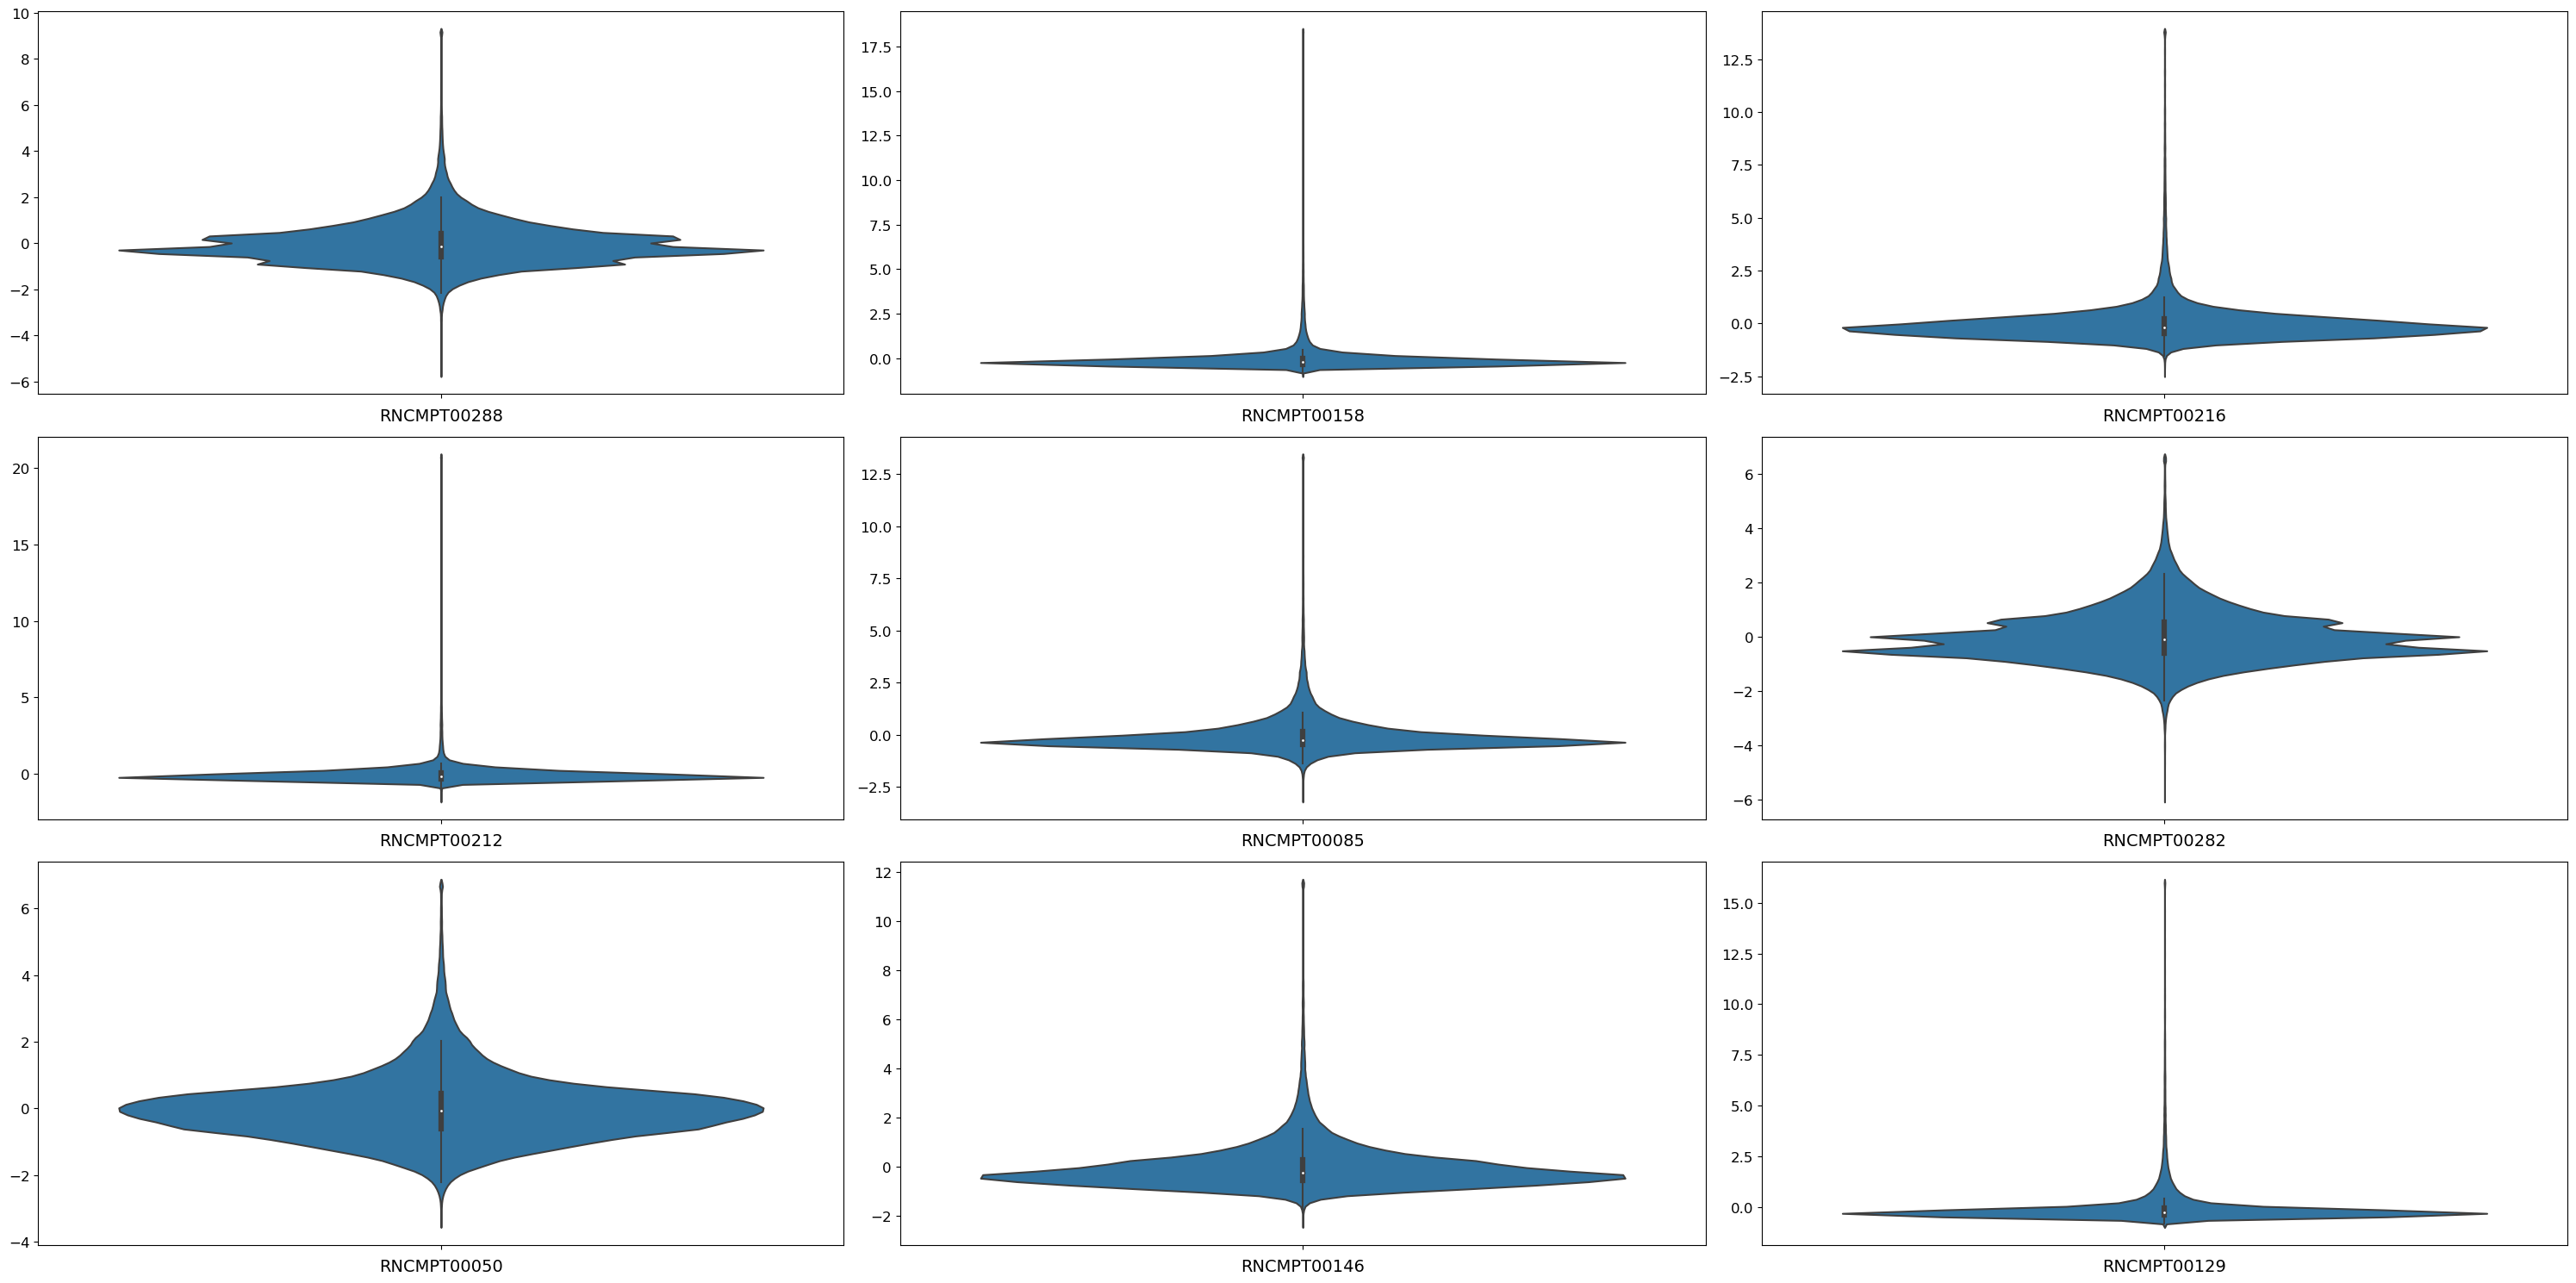

In [58]:
# Plot the distribution of the scaled targets
pl.violinplot(
    sdata_setA, 
    keys=random_cols
)
plt.show()

# Preprocess the test set
- We need to apply the clamping numbers from the training set to the test set.
- We need to apply the mean and standard deviation from the training set to the test set.

In [16]:
# Apply the same clamping to the test set
pp.clamp_targets_sdata(sdata_setB, target_keys=target_cols, clamp_nums=sdata_setA["clamp_nums"].to_series())

In [17]:
# Check the clamping
sdata_setB[random_cols].to_dataframe().describe()

,RNCMPT00262,RNCMPT00165,RNCMPT00199,RNCMPT00131,RNCMPT00122,RNCMPT00226,RNCMPT00151,RNCMPT00084,RNCMPT00080
count,121005.000000,120389.000000,121000.000000,121020.000000,120988.000000,121020.000000,120392.000000,120285.000000,121029.000000
mean,0.288033,0.655732,0.232570,0.182403,1.375836,0.546934,0.304152,0.217853,0.042696
std,1.738431,2.803783,1.271066,1.351552,14.575159,2.555136,1.646087,1.678750,1.768522
min,-7.660918,-3.519481,-4.262478,-4.125763,-7.385627,-5.984399,-3.867944,-4.278111,-10.971053
25%,-0.586120,-0.589566,-0.612359,-0.611752,-0.596342,-0.592160,-0.608054,-0.626747,-0.657891
50%,-0.001023,0.000268,-0.000024,-0.000802,0.000398,0.005795,0.001100,0.000652,0.000156
75%,0.808766,0.862736,0.777901,0.744865,0.736130,0.829005,0.773807,0.732249,0.681607
max,22.667843,39.277073,12.196100,19.948473,476.839499,40.043609,16.779537,30.859128,32.218491


In [18]:
# Apply the same scaling to the test set
pp.scale_targets_sdata(sdata_setB, target_keys=target_cols, scaler=scaler, suffix=False, return_scaler=False)

In [19]:
# Check the scaling
sdata_setB[random_cols].to_dataframe().describe()

,RNCMPT00262,RNCMPT00165,RNCMPT00199,RNCMPT00131,RNCMPT00122,RNCMPT00226,RNCMPT00151,RNCMPT00084,RNCMPT00080
count,121005.000000,120389.000000,121000.000000,121020.000000,120988.000000,121020.000000,120392.000000,120285.000000,121029.000000
mean,-0.002856,0.000054,0.002251,0.004075,-0.007694,0.000859,-0.001666,0.004051,-0.005254
std,0.998177,1.006568,1.000867,1.033166,0.894766,0.992320,1.003133,0.993959,0.990138
min,-4.567006,-1.498862,-3.537252,-3.289212,-0.545558,-2.535667,-2.544159,-2.657933,-6.171494
25%,-0.504779,-0.447013,-0.663065,-0.603000,-0.128766,-0.441522,-0.557569,-0.496022,-0.397490
50%,-0.168827,-0.235260,-0.180899,-0.135972,-0.092132,-0.209299,-0.186348,-0.124550,-0.029071
75%,0.296140,0.074369,0.431657,0.434037,-0.046965,0.110406,0.284543,0.308616,0.352451
max,12.847243,13.865249,9.422608,15.113830,29.180914,15.339896,10.038503,18.146225,18.008925


In [20]:
# Take subset for testing, only for tests/use_cases/ray13
sdata_setA_sub = sdata_setA.isel(_sequence=slice(100))
sdata_setB_sub = sdata_setB.isel(_sequence=slice(100))

In [24]:
# Save the processed data
sd.to_zarr(sdata_setA_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setA_sub_ST.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setB_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setB_sub_ST.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setA, os.path.join(settings.dataset_dir, "ray13", "norm_setA_ST.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setB, os.path.join(settings.dataset_dir, "ray13", "norm_setB_ST.zarr"), load_first=True, mode="w")

# Generate multitask ready data
 - With single task training, we can just filter out NaNs and train on the remaining data.
 - We can't do this for multitask training, so we need to generate a separate `SeqData` object where there are no NaNs.

In [25]:
# Get the columns that you would keep if you removed columns with a certain percentage of missing values
nan_cutoff = 0.01
nan_percents = sdata[target_cols].to_dataframe().isna().sum(axis=0).sort_values(ascending=False)/sdata.dims["_sequence"]
remove_cols = nan_percents[nan_percents > nan_cutoff].index
keep_cols = target_cols.drop(remove_cols)
len(keep_cols)

233

In [26]:
# Make a copy of the training data and subset it to only the columns with < nan_cutoff missing values
sdata_setA_MT = sdata_setA.copy()
sdata_setA_MT = sdata_setA_MT.drop(list(remove_cols) + ["_targets", "clamp_nums"])

In [27]:
# Get rid of any sequences that have missing values in the remaining target columns
keep_rows = np.where(sdata_setA_MT[keep_cols].to_dataframe().isna().sum(axis=1) == 0)[0]
sdata_setA_MT = sdata_setA_MT.isel(_sequence=keep_rows)

In [28]:
# We also need to remove the columns from the Set B object, but we don't need to remove any rows since we can just ignore those in the evaluation stage
sdata_setB_MT = sdata_setB.copy()
sdata_setB_MT = sdata_setB_MT.drop(list(remove_cols))

In [30]:
# Double check that the shapes make sense (Set A object has 2 extra columns, one set and one for train/val split. Set B object has 1 extra column, jus the set)
(sdata_setA_MT.dims["_sequence"], len(sdata_setA_MT.data_vars)), (sdata_setB_MT.dims["_sequence"], len(sdata_setB_MT.data_vars))

((110645, 238), (121031, 237))

In [31]:
# Check if copy worked
(sdata_setA.dims["_sequence"], len(sdata_setA.data_vars)), (sdata_setB.dims["_sequence"], len(sdata_setB.data_vars))

((120326, 250), (121031, 248))

In [35]:
# Doubke check that there are no missing values in the remaining columns
sdata_setA_MT[keep_cols].to_dataframe().isna().sum().sum()

0

In [37]:
# Take subset for testing
sdata_setA_MT_sub = sdata_setA_MT.isel(_sequence=slice(100))
sdata_setB_MT_sub = sdata_setB_MT.isel(_sequence=slice(100))

In [38]:
# Save the processed data
sd.to_zarr(sdata_setA_MT_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setA_sub_MT.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setB_MT_sub, os.path.join(settings.dataset_dir, "ray13", "norm_setB_sub_MT.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setA_MT, os.path.join(settings.dataset_dir, "ray13", "norm_setA_MT.zarr"), load_first=True, mode="w")
sd.to_zarr(sdata_setB_MT, os.path.join(settings.dataset_dir, "ray13", "norm_setB_MT.zarr"), load_first=True, mode="w")

# Generating a presence/absence matrix per probe
- We need to generate a presence/absence matrix per probe to use for evaluation
    - This presence/absence matrix is a binary matrix where the rows are all possible k-mers and the columns are probes.
    - The value of a cell is 1 if the k-mer is present in that probe and 0 otherwise.

> **Note**
> Each one of these matrices takes about 15 minutes to generate!

In [45]:
# Helper function to generate a presence/absence matrix
from ray13_helpers import generate_all_possible_kmers, kmer_in_seqs

In [46]:
# Generate all possible 7-mers and check
a_probes = pd.Series(sdata_setA["RNA_Seq"].to_series())
a_probes_MT = pd.Series(sdata_setA_MT["RNA_Seq"].to_series())
b_probes = pd.Series(sdata_setB["RNA_Seq"].to_series())
kmers = generate_all_possible_kmers(n=7, alphabet="ACGU")
len(a_probes), len(a_probes_MT), len(b_probes), len(kmers)

(120326, 110645, 121031, 16384)

In [ ]:
# Generate the Set A presence/absence matrix
a_hits = np.array([a_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setA_binary_ST"), a_hits)
a_hits.shape, np.all((a_hits == 1).sum(axis=1) >= 155)

In [ ]:
# Generate the Set A presence/absence matrix
a_hits_MT = np.array([a_probes_MT.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setA_binary_MT"), a_hits)
a_hits_MT.shape, np.all((a_hits_MT == 1).sum(axis=1) >= 155)

In [ ]:
# Generate the Set B presence/absence matrix
b_hits = np.array([b_probes.str.contains(kmer).astype(int).values for i, kmer in tqdm(enumerate(kmers), desc="Searching for kmers in probes", total=len(kmers))])
np.save(os.path.join(eu.settings.dataset_dir, "ray13", "setB_binary"), b_hits)
b_hits.shape,  np.all((b_hits == 1).sum(axis=1) >= 155)

# DONE!

---

# Scratch

In [47]:
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"

In [53]:
for zarr in ["norm_setA_sub_MT.zarr", "norm_setB_sub_MT.zarr", "norm_setA_MT.zarr", "norm_setB_MT.zarr"]:
    sdata = sd.open_zarr(os.path.join(settings.dataset_dir, zarr))
    print(zarr, sdata.dims["_sequence"], len(sdata.data_vars))
    if "train_val" in sdata.data_vars:
        print(np.unique(sdata["train_val"].values, return_counts=True))
    else:
        print("No train_val column found")

norm_setA_sub_MT.zarr 100 238
(array([False,  True]), array([20, 80]))
norm_setB_sub_MT.zarr 100 237
No train_val column found
norm_setA_MT.zarr 110645 238
(array([False,  True]), array([22200, 88445]))
norm_setB_MT.zarr 121031 237
No train_val column found


In [55]:
for zarr in ["norm_setA_sub_ST.zarr", "norm_setB_sub_ST.zarr", "norm_setA_ST.zarr", "norm_setB_ST.zarr"]:
    sdata = sd.open_zarr(os.path.join(settings.dataset_dir, zarr))
    print(zarr, sdata.dims["_sequence"], len(sdata.data_vars))
    if "train_val" in sdata.data_vars:
        print(np.unique(sdata["train_val"].values, return_counts=True))
    else:
        print("No train_val column found")

norm_setA_sub_ST.zarr 100 250
(array([False,  True]), array([21, 79]))
norm_setB_sub_ST.zarr 100 248
No train_val column found
norm_setA_ST.zarr 120326 250
(array([False,  True]), array([24066, 96260]))
norm_setB_ST.zarr 121031 248
No train_val column found
